# Gradient Boosting: Appliance and Optimization

The field of Machine Learning (ML) implements quite a lot of different algorithms to achieve domain specific goals. Bioinformatics is one of those domain specifics where we try to create a **descision space** based on biomarkers (a set of features that result from biological results, allowing us to classify an organism as *A* or *B*).

Within the field of bioinformatics, we often work with both **Structured** and **Unstructured** data. These are the 2 main classification by which ML engineers decide on an algorithm. Structured data is acquired from locations such as: **SQL**, **CSV (Excel)** and **Text** documents. **Unstructured** data is commonly referred to as Images or Speech, which is very hard to model with Structured Oriented algorithms.

For our specific project, we work with **Structured** data (Yay!). Structured data allows for *a lot* of different implementations, but the most used implementation is a **Desicion Tree Classifier (DTC)**. A DTC utilizes the idea of *Gini Impurity* (most generally): trying to find a path through a given **if ... else ...** that provides the most robust classification result.

However, a major drawback of DTCs is **overfitting**. Overfitting means: The model takes too much **Variance** of data into consideration when deciding on its **decision space**. Yet, we would like to build a model that *generalizes* over our training data so we can apply it as broadly to our problem as possible.

This major DTC problem is prevented by using **Gradient Boosting**. Gradient Boosting tries to find the optimal DTC by *iteratively* creating new, and most importantly, better DTCs. The allocated [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm ensure we move the tree into a 'negative' manner (gradient **descent**), allowing us to find the DTC with the least amount of prediction loss.

But: iteratively getting the best DTC? Doesn't this mean it will **always** overfit to the data?! Well, no. Gradient Boosting implements an **Overfitting Detection** technique through *Cross-Validation* (Let me know if you need futher explanation on CV, but I will skip it for now). As soon as the optimized DTC starts to get an accuracy estimation (e.g. AUC) from its respective CV, and the difference between the previous scoring and the current scoring is worse than a given threshold *Y*, the iterations will hault and the respective DTC is returned.

*Why this specific metric to detect overfitting?* If you remember the overfitting definition (taking too much variance into account): the validation set will perform a lot worse for an overfitted model than a generalized model. It's overfitting so drammatically, it can't even predict a dataset that looks a lot like our training data!

Combining all of these methods makes Gradient Boosting so incredibly powerful. You simply preprocess the data, create a model object and let the framework do the rest :)

## Imports

To implement all of the gibberish above, we need to use some essential Python Libraries.

- **typing** is used to declare *types* in python. Ensuring we do not randomly combine data objects.

- **NumPy** is an optimized matrix calculator.
- **Pandas** is an extremely common Data Wrangler library that allows us to easily interact with the Structured data
- **SKlearn** is a common Machine Learning Library that allows us to quickly produce Pipelines
- **CatBoost** is a relatively new competitor in the field of Gradient Boosting but very powerfull by utilizing the lastest and greatest research findings.
- **XGBoost** is the most widely used Gradient Boosting framework in the field of ML. A 'no-brainer' for our comparisons!

- **custom_functions** simply provides some helper-functions :)

In [ ]:
from typing import *

import numpy as np
import pandas as pd
import sklearn as sk
import catboost as cb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from custom_functions import (
    store_json,
    load_json,
)

In [ ]:
# Additionally, I will set some constants. 
# This is a pythonic way of writing code since 
# it makes it easier for new developers to 
# quickly change recurring values.

DROPPABLE_COLUMNS:List = ["Unnamed: 0",]
TEST_SIZE:float = 0.20
RANDOM:int = 44

# Normally, I would add the model params
# as well but for the sake of structure:
# I put them with their respective models

## Data Acquisition

Normally, preprocessing is an **essential** step to allow for (effective) predictive modelling. Yet, this has already been done for us! (Class imbalance, independent variable distribution, etc etc). So, all we need to do is getting our Structured Data ready for the model.

Machine Learning works with **Instances** and **Features**. e.g. in a research on biomarkers for Human cancer classification, humans are the instances and the different genes are features. Where a gene count presents the feature value (in our case, -1/0/1/2). Our project requirement is the **classification of each array into a specific tumor subtype**. Therefore, the Arrays become the instances and the different chromosomal regions become the features.

The whole Instance vs Features stuff has been performed within the 'PreAnalysis' notebook. So we only need to access the processed data using Pandas.

In [ ]:
df = pd.read_csv("./data/superset.csv")
df = (df
    .set_axis([df["Unnamed: 0"]]) # A common artefact of pandas since it tries to reset the index
    .drop(columns=DROPPABLE_COLUMNS) # Now we can delete the artefact since it's redundant (values are now inside of the index)
)

In [ ]:
df.Subgroup = df.Subgroup.replace(
    {cat:num for num, cat in enumerate(df.Subgroup.unique())}
    )
# An ML model doesn't really understand strings (text) like we do. 
# Therefore, we simply transform the individual string values in a simple numerical value (1 = HER,2 = HR, etc etc). 

In [ ]:
df.shape # 100 Instances with 2835 features each

(100, 2835)

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,2825,2826,2827,2828,2829,2830,2831,2832,2833,Subgroup
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,...,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00,100.000000,100.000000,100.00000
mean,0.030000,-0.050000,-0.030000,0.010000,-0.030000,-0.040000,-0.040000,-0.100000,-0.10000,-0.100000,...,1.130000,1.040000,1.130000,1.09000,1.120000,1.130000,1.15,1.130000,1.120000,1.00000
std,0.481055,0.457817,0.459578,0.481894,0.521362,0.490722,0.510891,0.541229,0.57735,0.522233,...,0.463953,0.530294,0.463953,0.51434,0.455716,0.485237,0.50,0.525222,0.498077,0.80403
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00,1.000000,1.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00,1.000000,1.000000,1.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00,1.000000,1.000000,2.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.00000,1.000000,...,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.00,2.000000,2.000000,2.00000


The describe function shows a nice recurring pattern of mean = 0.03 or -0.05 or -0.01 etc etc. AKA there is nothing weird going on, which is very nice :3

## Data Splitting

Since we would like to test the accuracy of our model, it's vital to have a **test set**. This allows us to score the model's accuracy on a similar, but not identical, dataset. SKlearn has an integrated *train_test_split* function that will take of this process. We only need to define the test set fraction and the random state. The fraction is currently at 0.25 (creating 25 test samples) with a random state of 44.

Normally, such little test size would cause severe problems for a production model. But we are limited to 100 instances so it's all we are gonna get.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Using an underscore so no1 accidently uses the original dataset
X_ = df.drop(columns=["Subgroup"])
y_ = df.Subgroup

# Initial Datasets
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=TEST_SIZE, random_state=RANDOM)

# p.s. The reason for random_state has to do with reproducibility. SKlearn utilizes random permutations that bases its number on the provided seed. 
# This is not essential for our project but is a very good practice to remember for a scientific setting.

Not all frameworks apply Cross-Validation within their training pipeline. Therefore, we manually split some data from the training set to act as *validation data*. The model can use this to score its intermediate evaluations without being exposed to the final test set.

In [ ]:
X_trainset, X_val, y_trainset, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM)

# Building The Different Models

Now comes the fun part! Let's build some models :D

We will apply the following frameworks for comparison (besides our 'Simple Baseline Model'):
- Sklearn
- CatBoost
- XGBoost

## Model Comparison

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, cross_val_score

In [ ]:
kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=RANDOM)

In [ ]:
# parameters

sklearn_params = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [50,100,150,200],
    'max_depth': [2,3,4,5,6],
    'min_samples_split': [1,2,4,6],
    'min_samples_leaf': [1,2,3],
    'subsample': [1,1.5,2,2.5],
    'max_features': ["auto", "sqrt", "log2"],
}

xgboost_params = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': [0.05, 0.01, 0.1],
    # 'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    # 'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    # 'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

catboost_params = {
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [2,3,4,5,6],
    # 'subsample': [1, 1.5, 2, 2.5],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
}

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
sklearn_clf = GradientBoostingClassifier();

xgboost_clf = XGBClassifier();

catboost_clf = CatBoostClassifier();

In [ ]:
searched_sklearn = RandomizedSearchCV(
    sklearn_clf, 
    param_distributions=sklearn_params, 
    n_jobs=-1, 
    cv=kfold, 
    verbose=3, 
    random_state=RANDOM)

In [ ]:
searched_xgboost = RandomizedSearchCV(
    xgboost_clf, 
    param_distributions=xgboost_params, 
    n_jobs=-1, 
    cv=kfold, 
    verbose=3, 
    random_state=RANDOM)

In [ ]:
# searched_catboost = RandomizedSearchCV(
#     catboost_clf, 
#     param_distributions=catboost_params, 
#     n_jobs=-1, 
#     cv=kfold, 
#     verbose=3, 
#     random_state=RANDOM)

# This does not work, due to the fractioning of sklearn. We will use the internal randomized search.

In [ ]:
searched_sklearn.fit(X_trainset, y_trainset)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.58888889 0.68333333        nan
        nan        nan 0.55952381        nan]
  warnings.warn(


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=44),
                   estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.01],
                                        'max_depth': [2, 3, 4, 5, 6],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [1, 2, 4, 6],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [1, 1.5, 2, 2.5]},
                   random_state=44, verbose=3)

In [ ]:
searched_xgboost.fit(X_trainset, y_trainset)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
/root/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:46:22] WARNING: ../src/learner.cc:573: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:46:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric 

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=44),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mi...
                                                       0.26530612244897955,
                                                       0.2857142857142857,
                                                       0.3061224489795918,
                                         

In [ ]:
searched_catboost = catboost_clf.randomized_search(
    catboost_params,
    X=X_trainset,
    y=y_trainset,
)

1:	learn: 1.0485875	test: 1.1052674	best: 1.1042570 (0)
2:	learn: 1.0221957	test: 1.1029505	best: 1.1029505 (2)
3:	learn: 1.0045809	test: 1.1035247	best: 1.1029505 (2)
4:	learn: 0.9834457	test: 1.0913189	best: 1.0913189 (4)
5:	learn: 0.9698792	test: 1.0859919	best: 1.0859919 (5)
6:	learn: 0.9491423	test: 1.0817270	best: 1.0817270 (6)
7:	learn: 0.9322213	test: 1.0831759	best: 1.0817270 (6)
8:	learn: 0.9146557	test: 1.0733340	best: 1.0733340 (8)
9:	learn: 0.8852331	test: 1.0576039	best: 1.0576039 (9)
10:	learn: 0.8741405	test: 1.0481456	best: 1.0481456 (10)
11:	learn: 0.8208812	test: 0.9912559	best: 0.9912559 (11)
12:	learn: 0.8058605	test: 0.9914418	best: 0.9912559 (11)
13:	learn: 0.7949529	test: 0.9920079	best: 0.9912559 (11)
14:	learn: 0.7698098	test: 0.9709182	best: 0.9709182 (14)
15:	learn: 0.7271120	test: 0.9224817	best: 0.9224817 (15)
16:	learn: 0.7191841	test: 0.9221942	best: 0.9221942 (16)
17:	learn: 0.7035083	test: 0.9190465	best: 0.9190465 (17)
18:	learn: 0.6957157	test: 0.918

In [ ]:
# Get the scores
sklearn_scores = cross_val_score(
    searched_sklearn.best_estimator_, 
    X_train.values, 
    y_train.values, 
    cv=kfold)

xgboost_scores = cross_val_score(
    searched_xgboost.best_estimator_, 
    X_train.values, 
    y_train.values, 
    cv=kfold)

catboost_scores = cross_val_score(
    catboost_clf, 
    X_train.values, 
    y_train.values, 
    cv=kfold)

1:	learn: 1.0178454	total: 20.4ms	remaining: 10.2s
2:	learn: 0.9888855	total: 29.2ms	remaining: 9.69s
3:	learn: 0.9761943	total: 38ms	remaining: 9.47s
4:	learn: 0.9089840	total: 46.7ms	remaining: 9.29s
5:	learn: 0.8966704	total: 55.5ms	remaining: 9.2s
6:	learn: 0.8453845	total: 65.5ms	remaining: 9.29s
7:	learn: 0.8281469	total: 74.2ms	remaining: 9.2s
8:	learn: 0.8186429	total: 83.6ms	remaining: 9.21s
9:	learn: 0.8020965	total: 110ms	remaining: 10.9s
10:	learn: 0.7915441	total: 120ms	remaining: 10.8s
11:	learn: 0.7780281	total: 129ms	remaining: 10.6s
12:	learn: 0.7291908	total: 138ms	remaining: 10.5s
13:	learn: 0.6888848	total: 147ms	remaining: 10.3s
14:	learn: 0.6750419	total: 155ms	remaining: 10.2s
15:	learn: 0.6657442	total: 164ms	remaining: 10.1s
16:	learn: 0.6502445	total: 173ms	remaining: 9.99s
17:	learn: 0.6246869	total: 182ms	remaining: 9.9s
18:	learn: 0.6176848	total: 190ms	remaining: 9.83s
19:	learn: 0.6139357	total: 215ms	remaining: 10.5s
20:	learn: 0.6070957	total: 225ms	rem

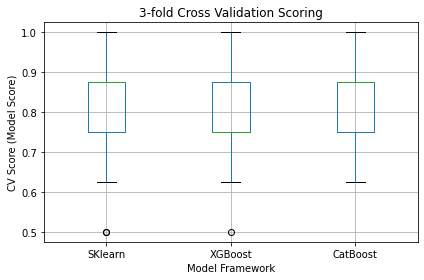

In [ ]:
try:
    
    # Plot the scores as boxplots
    pd.DataFrame({
        "SKlearn": sklearn_scores,
        "XGBoost": xgboost_scores,
        "CatBoost": catboost_scores,
    }).boxplot()

    plt.ylabel("CV Score (Model Score)")
    plt.xlabel("Model Framework")

    plt.title("3-fold Cross Validation Scoring")
    plt.tight_layout()
    # plt.savefig("./model_comparison.png")
    plt.show()

except:
    print("Failed to plot")
    pass

In [ ]:
# 'Absolute' scoring
sklearn_y_pred = searched_sklearn.best_estimator_.predict(X_val)

xgboost_y_pred = searched_xgboost.best_estimator_.predict(X_val)

catboost_y_pred = catboost_clf.predict(X_val)

estimators = {
    "sklearn": sklearn_y_pred,
    "xgboost": xgboost_y_pred,
    "catboost": catboost_y_pred,
}

for est in estimators:
    try:
        score = estimators[est] - y_val.values # NumPy allows for matrix operations, yay!
    except:
        score = estimators[est].reshape(-1) - y_val.values

    result = 1-len(score[score != 0])/len(score)
    print(f"The scoring for {est} is: \t{result}")

The scoring for sklearn is: 	0.6875
The scoring for xgboost is: 	0.8125
The scoring for catboost is: 	-9.0
/root/venv/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


/root/venv/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


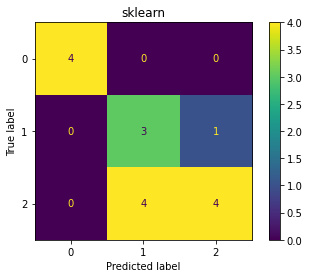

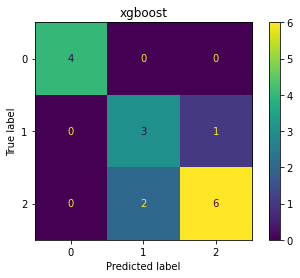

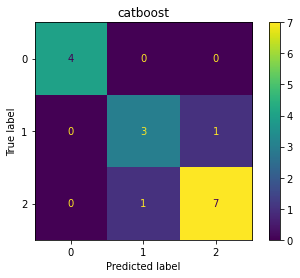

In [ ]:
from sklearn.metrics import plot_confusion_matrix

classifiers = {
    "sklearn": searched_sklearn.best_estimator_,
    "xgboost": searched_xgboost.best_estimator_,
    "catboost": catboost_clf,
}

for clf in classifiers:
    plot_confusion_matrix(classifiers[clf], X_val, y_val)
    plt.title(clf)

## XGBoost

In [ ]:
XGBGBC_params = {
    'n_estimators': 200,
    'learning_rate': 0.01,
    'max_depth': 6,
    'n_jobs': 4,
    'random_state': RANDOM }

XGBGBC = xgb.XGBClassifier(**XGBGBC_params)

In [ ]:
# X_trainset, X_val, y_trainset, y_val
XGBGBC.fit(X_sparse_train, y_trainset)

/root/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[08:30:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=44, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb_y_pred = XGBGBC.predict(X_sparse_val)

/root/venv/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [ ]:
score = xgb_y_pred - y_val.values
mean = 1-len(score[score != 0])/len(score)
mean

0.875

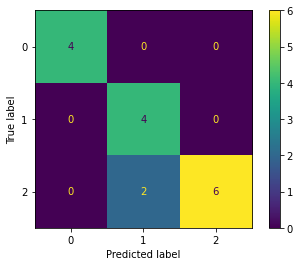

In [ ]:
plot_confusion_matrix(XGBGBC, X_sparse_val, y_val)

## Baseline: Random Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

# “stratified”: generates (random) predictions by respecting the training set’s class distribution.
# "uniform": generates random predicitions using uniform distribution

BDC = DummyClassifier(strategy="stratified")
BDC.fit(X_sparse_train, y_trainset)

bdc_y_pred = BDC.predict(X_sparse_val)

score = bdc_y_pred - y_val.values
mean = 1-len(score[score != 0])/len(score)
mean

0.3125

In [ ]:
BDC_small_scores = cross_val_score(BDC, X_sparse_train.values, y_trainset.values, cv=sk_cv)
print(BDC_small_scores.mean()*100)
print(BDC_small_scores.std()*100)


17.05315301387956

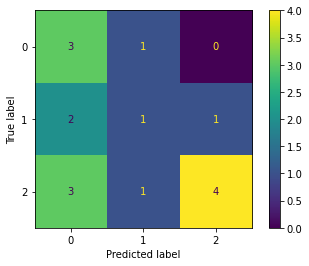

In [ ]:
plot_confusion_matrix(BDC, X_sparse_val, y_val)

## Baseline: Multinomial Logit

In [ ]:
from sklearn.linear_model import LogisticRegression

BML_params = {
    'solver': 'saga',
    'max_iter': 100,
    'penalty': 'l1',
    'random_state': 0}

BML = LogisticRegression(**BML_params)

BML.fit(X_sparse_train, y_trainset)

bml_y_pred = BDC.predict(X_sparse_val)

score = bml_y_pred - y_val.values
mean = 1-len(score[score != 0])/len(score)
mean


0.375

In [ ]:
BML_small_scores = cross_val_score(BML, X_sparse_train.values, y_trainset.values, cv=sk_cv)
print(BML_small_scores.mean()*100)
print(BML_small_scores.std()*100)

18.962940080532302

In [ ]:
BML_small_scores.mean()*100

65.15873015873017

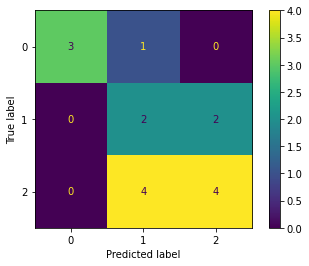

In [ ]:
plot_confusion_matrix(BML, X_sparse_val, y_val)

## Plot the training vs validation to identify overfitting


In [ ]:
# WIP
# attempt to plot the training process(https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html)
# training vs validation deviance

y_val_list = y_val.to_numpy()

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(GBC.staged_predict(X_val)):
    test_score[i] = GBC.loss_(y_val_list, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

NameError: name 'params' is not defined

## k-fold cross-validation:
It seems like you can implement the cross-validation for the train-validation split in this way. (Use to evaluate different models using k-fold CV on the training set
 & pick the final model, which is then used to predict the test set!)

 *Question*: 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = GBC
kfold = KFold(n_splits=7,shuffle = True, random_state=10)
results = cross_val_score(model, X_trainset, y_trainset, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 76.79% (12.37%)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c915e4f9-60c2-40b5-a522-8a90cb3fd50a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>